In [1]:
from geopy.geocoders import Nominatim
import folium 
from folium.plugins import MarkerCluster 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd # Recolección y manipulación de datos

In [13]:
# We will use Nominatim to get the coordinates of the houses we're interested in
geolocator = Nominatim(user_agent= 'example app', timeout=3)

In [2]:
# We load the csv that we obtained from the webscrapper 
data = pd.read_csv('/content/Inmuebles24_Aguascalientes.csv')

In [3]:
# We drop the columns that are not useful for us 
df= data.drop("Unnamed: 0", axis=1)
df = df.drop("Unnamed: 0.1", axis=1)

In [4]:
# The webscrapper is designed to fill the mising data with N/A on directions and 0 where no data is given
df.isnull().sum()

Price                    0
Mantainance_cost         0
Total_area [m^2]         0
Constructed_area[m^2]    0
No_rooms                 0
No_bathrooms             0
No_parkings              0
Location                 0
dtype: int64

In [5]:
# Even when we don't have missing values we mostlikely have duplicated values 
df = df.drop_duplicates()

In [6]:
# We can see we've passed from 2328 observations to only 1427 when deleting the duplicated values 
df.shape

(1427, 8)

In [7]:
# We can describe the data after we've deleted the duplicates 
df.describe()

,Price,Mantainance_cost,Total_area [m^2],Constructed_area[m^2],No_rooms,No_bathrooms,No_parkings
count,1.427000e+03,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000
mean,2.393996e+07,184.234057,2841.023826,218.784163,2.301331,1.743518,2.010512
std,1.884857e+08,986.516111,25533.877987,2133.697676,1.669466,1.589792,9.351513
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.250000e+06,0.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,2.597328e+06,0.000000,160.000000,127.000000,3.000000,2.000000,2.000000
75%,4.500000e+06,0.000000,252.000000,216.000000,3.000000,3.000000,2.000000
max,2.350000e+09,10000.000000,800000.000000,80000.000000,15.000000,15.000000,200.000000


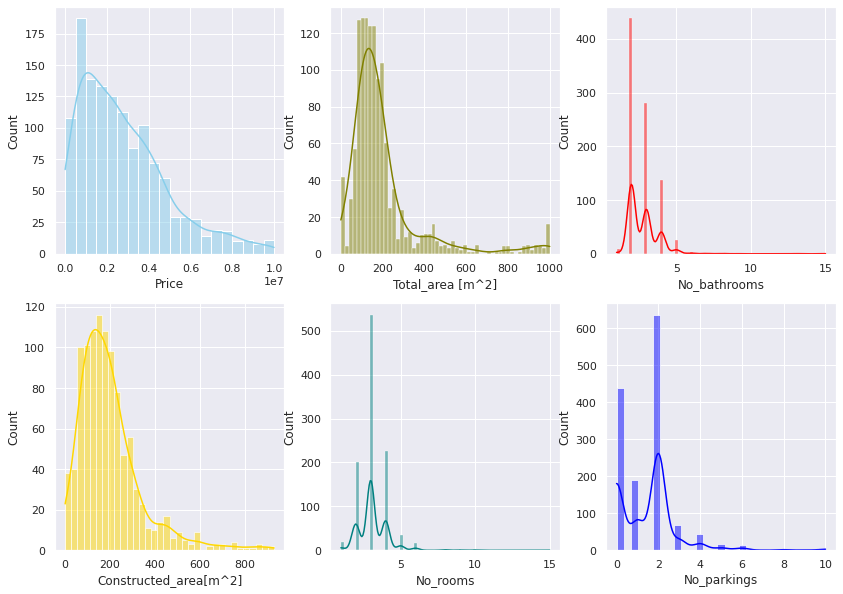

In [8]:
# We wil create some plots to show the distribution of the parameters, for this we need to fiter our data according to
# the needs of the client, on this case I'm looking for houses that are valued in less than 10M 
# we want a house with at least one bathroom and at least one room.  

fig, axs = plt.subplots(2, 3, figsize=(14, 10))

sns.histplot(data=df[(df['Price'] <= 10000000)], x='Price', kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df[(df['Total_area [m^2]'] <= 1000)],  x='Total_area [m^2]', kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df[(df['No_bathrooms'] <= 15) & (df['No_bathrooms'] > 0)],  x='No_bathrooms', kde=True, color="red", ax=axs[0, 2])
sns.histplot(data=df[(df['Constructed_area[m^2]'] <= 1000) & (df['Constructed_area[m^2]'] > 0)],  x='Constructed_area[m^2]', kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df[(df['No_rooms'] > 0)],  x='No_rooms', kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df[(df['No_parkings'] <= 10)],  x='No_parkings', kde=True, color="blue", ax=axs[1, 2])



In [9]:
# Now it's time to filter the data to delete the fake or ilogical posts and to storage only the houses we're interested in
df_f = df[( df['Price'] <= 10000000) & (df['Total_area [m^2]'] <=1000) & (df['Total_area [m^2]'] > 0) & (df['No_bathrooms'] <= 15) & (df['No_bathrooms'] > 0) & (df['Constructed_area[m^2]'] <= 1000) & (df['Constructed_area[m^2]'] > 0) & (df['No_rooms'] > 0) & (df['No_parkings'] <= 10)]

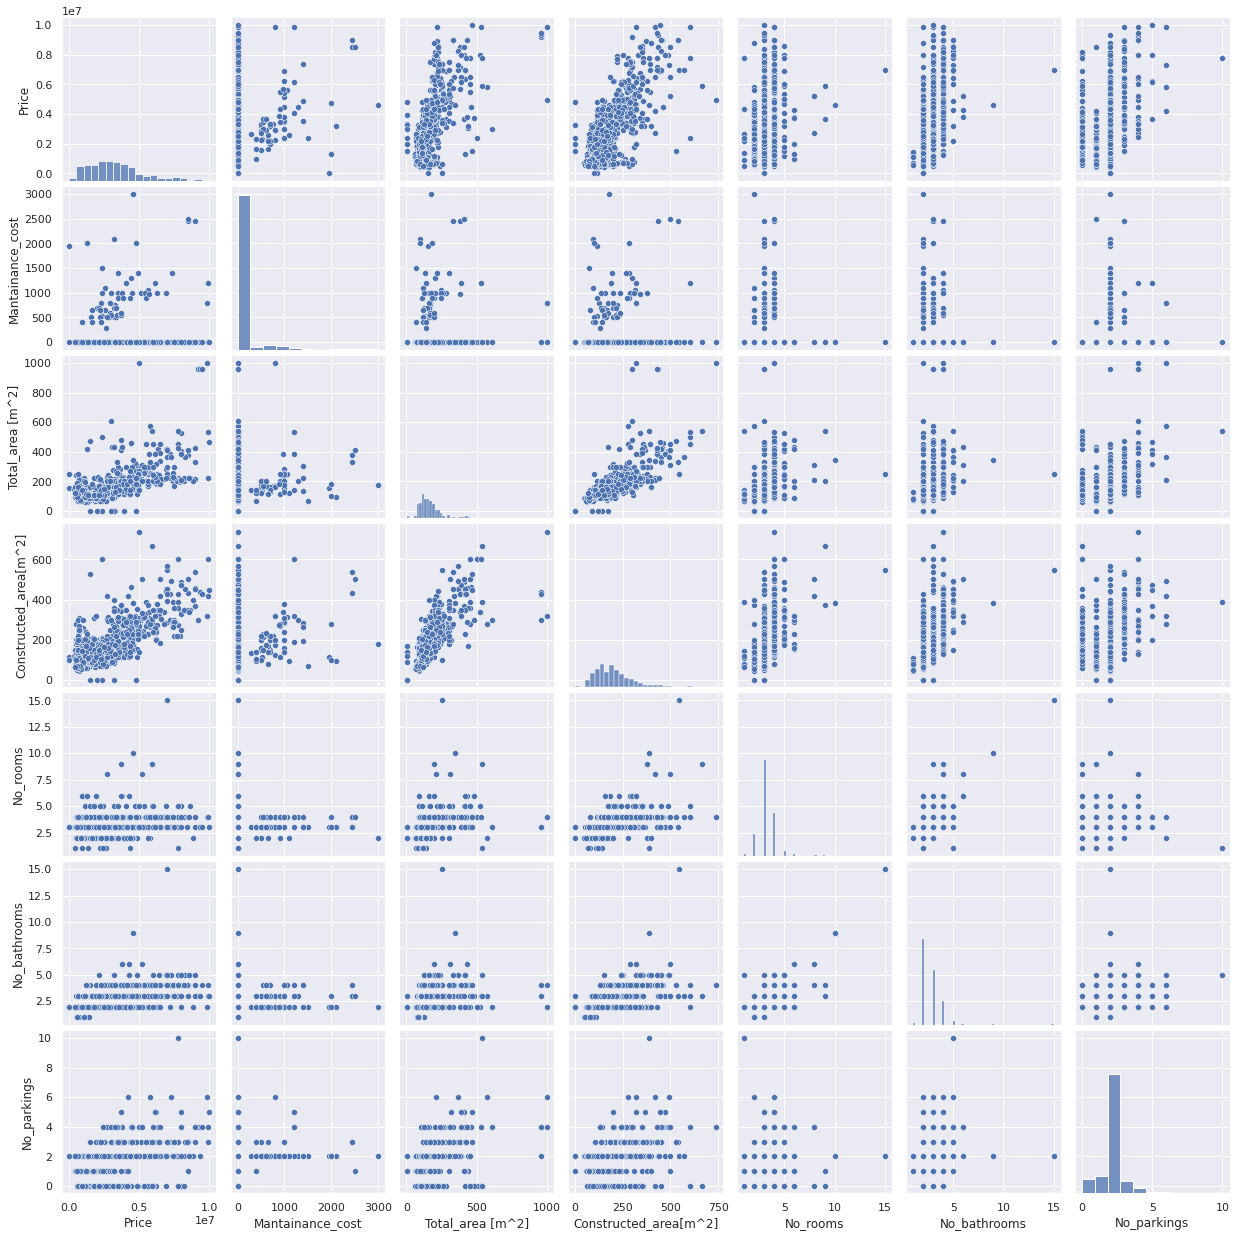

In [10]:
sns.pairplot(df_f)

In [14]:
#Now we will use geolocator to get the coordinates of the houses we're interested in 
df_f["loc"] = df_f["Location"].apply(geolocator.geocode)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
df_f["point"] = df_f["loc"].apply(lambda loc: tuple(loc.point) if loc else None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_f[['lat', 'lon', 'altitude']] = pd.DataFrame(df_f['point'].to_list(), index = df_f.index)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [19]:
#We will save the dataframe with the locations in case we needed 
df_f.to_csv("Inmuebles24_Aguascalientes_loc.csv")

In [20]:
m = folium.Map(location = df_f[['lat', 'lon']].mean().to_list(), zoom_star = 2)

marker_cluster = MarkerCluster().add_to(m)

In [24]:
# We can't create the map because we didn't get all the locations so we need to drop the ones we didn't find, this can be made using the API 
# of Google maps to obtain better results 
df_fi = df_f.dropna()

In [25]:
for i, r in df_fi.iterrows() : 
  location = (r["lat"], r["lon"])
  folium.Marker(location = location, popup = r['Price']).add_to(marker_cluster)

In [26]:
# We will show the map with the locations found using Nominatum, some of them are not in the state of Aguascalientes, 
#this can be done much better using Google API 
m

In [29]:
#Once again we can describe the data and compared it with the origina data 
df_f.describe()-df.describe()

,Constructed_area[m^2],Mantainance_cost,No_bathrooms,No_parkings,No_rooms,Price,Total_area [m^2],altitude,lat,lon
count,-688.000000,-688.000000,-688.000000,-688.000000,-688.000000,-6.880000e+02,-688.000000,NaN,NaN,NaN
mean,-17.830171,-95.253002,0.957429,-0.091702,0.943594,-2.061008e+07,-2664.229510,NaN,NaN,NaN
std,-2032.996110,-655.156823,-0.611083,-8.426750,-0.670368,-1.865094e+08,-25425.235035,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,NaN,NaN,NaN
25%,130.000000,0.000000,2.000000,2.000000,3.000000,6.475000e+05,11.000000,NaN,NaN,NaN
50%,58.000000,0.000000,0.000000,0.000000,0.000000,4.022480e+05,0.000000,NaN,NaN,NaN
75%,32.000000,0.000000,0.000000,0.000000,1.000000,-1.550000e+05,-52.000000,NaN,NaN,NaN
max,-79262.000000,-7000.000000,0.000000,-190.000000,0.000000,-2.340020e+09,-799000.000000,NaN,NaN,NaN
